<a id="1"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Loading libraries</span>
</div>

In [1]:
import logging
import numpy
import numpy as np
import pandas as pd
from math import *
from datetime import datetime
from operator import itemgetter
from zipfile import ZipFile
from io import BytesIO
import pickle
from urllib.request import urlopen

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from numpy import inf
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error



import warnings
warnings.filterwarnings('ignore')

from functions import *
from fair_func import *

In [2]:
from pandas.api.types import CategoricalDtype


<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Loading and preparing the data</span>
</div>

In [7]:
data = pd.read_csv('RAIdata.csv')

<a id="3"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Exploring data</span>
</div>

In [8]:
data.shape

(61321, 206)

In [9]:
data["Default"].value_counts()

0.0    46752
1.0    14569
Name: Default, dtype: int64

In [10]:
data.head().T

,0,1,2,3,4
Unnamed: 0,0.000000,1.0000,2.000000,3.000000,4.0000
Age,54.000000,52.0000,28.000000,40.000000,31.0000
AppliedAmount,8505.000000,2230.0000,530.000000,1380.000000,530.0000
DebtToIncome,0.000000,0.0000,0.000000,0.000000,0.0000
ExpectedLoss,0.118622,0.0592,0.048764,0.071894,0.0437
...,...,...,...,...,...
WorkExperience_2To5Years,0.000000,1.0000,1.000000,0.000000,0.0000
WorkExperience_5To10Years,1.000000,0.0000,0.000000,1.000000,0.0000
WorkExperience_LessThan2Years,0.000000,0.0000,0.000000,0.000000,1.0000
WorkExperience_MoreThan25Years,0.000000,0.0000,0.000000,0.000000,0.0000


In [11]:
#pd.DataFrame(data.describe().T).to_csv('data_describe.csv')

<div class="alert alert-block alert-success">
<b>Inference:</b>
We can infer that the data has more 0's (False) when it comes to defaulter compared to 1's (True).  
Thus there are more non-defaulters than defaulters.
</div>

<span style="float:right;"> [TOC](#TOC) </span>

---

In [12]:
#0 if favourable [false, default = false]
#1 if unfavourable [true, default = True]
fav=0
unfav=int(not fav)

In [13]:
a='Gender_0.0' #Male
b='Education_5.0' #Higher Ed
c='Young' # Age group
d='HomeOwnershipType_1.0' #Owner 
e='HomeOwnershipType_8.0' #Mortgages
f='EmploymentStatus_5.0' #Entrepreneur
g="Tenant" #Tenant

i='LanguageCode_1' #Estonian
j='LanguageCode_2' #English
k="NrOfDependantslessthan3" #No of dependent less than 10 years
l='MaritalStatus_1.0' #Married
m='MaritalStatus_3.0' #Single
n='MaritalStatus_4.0' #Divorced

p="WrExLess10" #Work ex less than 10 years
q="WrExLess5" #Work ex less than 5 years


<div class="alert alert-block alert-info">
<b>Remember:</b> 

- Statistical Parity Difference should be between -0.1 and 0.1
- Disparate Impact should be between 0.90 and 1.10
- Negative sign shows that: the unprivileged group is worse in favourable outcome that privileged class (as the formula used it probability of unprivileged - probability of privileged), so in case you see a positive value, you may want to reconsider your choice of privileged and unprivileged groups <b>using the next two plots</b>
</div>


### Calculation for Statistical Parity and Disparate Impact for a given protected feature
**Declaring the protected feature (a.k.a sensitive feature) and privileged & unprivileged groups**  
Here we are trying to find bias on basis of a sensitive feature (that explains if the customer is Married or Otherwise)

In [14]:
choice = 'dep_4_wl10' #'MaritalStatus_1.0'
pval = 0 #privileged : see the above heatmaps
upval = int(not pval) #Unprivileged
#['HomeOwnershipType_8.0', 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0', 'WrExLess10']

In [15]:
label_names=['Default']
protected_attribute_names=[choice]
privileged_groups=[{choice: pval}]
unprivileged_groups=[{choice: upval }]

In [17]:
data['dep_MS4_wex10'] = data[['NrOfDependantslessthan3','MaritalStatus_4.0', 'WrExLess10']].min(axis=1)

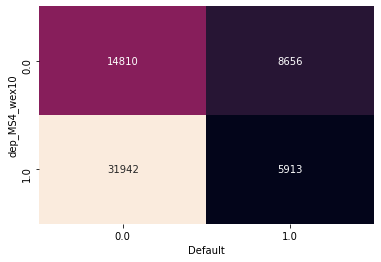

In [18]:
plotdf=pd.crosstab(data['dep_MS4_wex10'], data['Default'])
ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False)    #axes.plot(vc)
plt.show()
#print (type(axes))


In [19]:
datatest=data

**Missing value impuation for modelling**

In [20]:
datatest['MonthlyPayment'].fillna((datatest['MonthlyPayment'].mean()), inplace=True)
datatest['ExpectedLoss'].fillna((datatest['ExpectedLoss'].mean()), inplace=True)
datatest['ProbabilityOfDefault'].fillna((datatest['ProbabilityOfDefault'].mean()), inplace=True)
datatest['DebtToIncome'].fillna((datatest['DebtToIncome'].mean()), inplace=True)
datatest['FreeCash'].fillna((datatest['FreeCash'].mean()), inplace=True)
datatest['LossGivenDefault'].fillna(0, inplace=True)

In [21]:
target=['Default']

----

<a id="8"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Additive counterfactual fair model</span>
</div>

The implementation of a [**linear counterfactually fair**](https://arxiv.org/pdf/1703.06856.pdf) model uses the each of the protected class variable ($\mathbf{S}$) to compute the residuals for each input variable ($\mathbf{X}$) and then calculate the residuals as a difference between actual and predicted values ($\mathbf{X}-\hat{X}$) which is then used to learn a function that maps from inputs to the target variable ($\mathbf{Y}$). 

ACF,within the framework of counterfactual fairness, is the idea that we model the correlations between  ${S}$  and features in  ${X}$  by training linear models to predict each feature  ${X_j}$  using  ${S}$  as input.

Then, we can compute the residuals  ${ϵ_{ij}}$  between predicted and true feature values for each observation  ${i}$  and feature  ${j}$ . The final model is then trained on  ${ϵ_{ij}}$  as features to predict  ${y}$


$$
\begin{array}{c}{X_{1}=\beta_{0}+\beta_{1} S_{1}+\beta_{2} S_{2}+\cdots+\beta_{n} S_{n}+\epsilon_{1}} \\ {X_{n}=\beta_{0}+\beta_{1} S_{1}+\beta_{2} S_{2}+\cdots+\beta_{n} S_{n}+\epsilon_{n}} \\ {\epsilon_{X1}={X_{1}}-\hat{X_{1}}\left(S_{1}, S_{2}, \ldots, S_{n}\right)} \\ {\epsilon_{Xn}={X_{n}}-\hat{X_{n}}\left(S_{1}, S_{2}, \ldots, S_{n}\right)} \\ {Y=\beta_{0}+\beta_{1} \epsilon_{X1}+\cdots+\beta_{n} \epsilon_{Xn}}\end{array}
$$


<a id="8a"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:1.25em;">Classification (multiple protected features)</span>
</div>

<div class="alert alert-block alert-info">
<b>Remember:</b>
    
- Here the target variable is:
 - Default
- The independent variables are:
 - Age
 - AppliedAmount
 - ExpectedLoss
 - LiabilitiesTotal
 - IncomeTotal
 - Interest
 - LoanDuration
 - MonthlyPayment
- The sensitive variables are:
 - NrOfDependantslessthan3
 - MaritalStatus_1.0
 - MaritalStatus_3.0
 - MaritalStatus_4.0
</div>

In [23]:
choice = "MaritalStatus_1.0"

#"NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0'

In [24]:
dataacf = datatest[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal', 'IncomeTotal', 
                    'Interest', 'LoanDuration', 'MonthlyPayment',
"NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

## Full model : Logistic Regression


In [25]:
y=dataacf['Default']
x=dataacf.drop(columns=['Default'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

In [26]:
clf_full = LogisticRegression(random_state=0, solver='liblinear',
                              multi_class='ovr').fit(X_train, y_train)


In [27]:
y_pred=clf_full.predict(X_test)
y_pred_prob=clf_full.predict_proba(X_test)[:,0]
print("Accuracy of the full model:", clf_full.score(X_test, y_test))

Accuracy of the full model: 0.7721157766000816


In [28]:
A_full=clf_full.score(X_test[X_test[choice]==0], y_test[X_test[choice]==0]) #pval = 0 is Priviliged
B_full=clf_full.score(X_test[X_test[choice]==1], y_test[X_test[choice]==1]) #pval = 1 is Unpriviliged
print("Accuracy difference between two groups:", abs(B_full-A_full)*100, "%")

Accuracy difference between two groups: 12.75541766234911 %


In [29]:
1-roc_auc_score(y_test, y_pred_prob)

0.6867011492672429

In [30]:
(1-roc_auc_score(y_test[X_test[choice]==0], y_pred_prob[X_test[choice]==0])) - (1-roc_auc_score(y_test[X_test[choice]==1], y_pred_prob[X_test[choice]==1]))

0.03546606630359106

In [31]:
tn_up, fp_up, fn_up, tp_up = confusion_matrix(y_test[X_test[choice]==1], y_pred[X_test[choice]==1]).ravel()
tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_test[X_test[choice]==0], y_pred[X_test[choice]==0]).ravel()
#y_true, y_pred

In [32]:
Fullmodel = acfmetrics(tn_up, fp_up, fn_up, tp_up, tn_p, fp_p, fn_p, tp_p)

## Additive counterfactual fair model

In [33]:
y=dataacf['Default']
x=dataacf.drop(columns=['Default'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)

**Selecting few protected / sensitive features**

In [34]:
sens=X_train[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

**Regressing each independent variable with sensitive variable**

In [35]:
clf_age = LinearRegression().fit(sens, X_train['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_train['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_train['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_train['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_train['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_train['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_train['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_train['MonthlyPayment'])

**Residual of each model**

In [36]:
ageR = X_train['Age'] - clf_age.predict(sens)
AppliedAmountR = X_train['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_train['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_train['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_train['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_train['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_train['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_train['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)

In [37]:
df_R=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                   'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Fitting residuals to the dependent (target) variable**

In [38]:
fair = LogisticRegression(random_state=0, solver='liblinear',
                              multi_class='ovr').fit(df_R, y_train)

**Regressing each independent variable with sensitive variable on test data**

In [39]:
sens=X_test[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

In [40]:
clf_age = LinearRegression().fit(sens, X_test['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_test['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_test['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_test['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_test['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_test['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_test['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_test['MonthlyPayment'])

**Residual of each model on test data**

In [41]:
ageR = X_test['Age'] - clf_age.predict(sens)
AppliedAmountR = X_test['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_test['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_test['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_test['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_test['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_test['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_test['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)


In [42]:
df_R_test=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                        'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Predicting the target variable on fair model developed above**

In [43]:
pred_fair_te = fair.predict(df_R_test)

In [44]:
pred_fair_te_prob=fair.predict_proba(df_R_test)[:,0]

In [45]:
1-roc_auc_score(y_test, pred_fair_te_prob)

0.6084629184524863

In [46]:
(1-roc_auc_score(y_test[X_test[choice]==0], pred_fair_te_prob[X_test[choice]==0])) - (1-roc_auc_score(y_test[X_test[choice]==1], pred_fair_te_prob[X_test[choice]==1]))

-0.04409379360282961

In [47]:
tn_up, fp_up, fn_up, tp_up = confusion_matrix(y_test[sens[choice]==1], pred_fair_te[sens[choice]==1]).ravel()
tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_test[sens[choice]==0], pred_fair_te[sens[choice]==0]).ravel()
#y_true, y_pred

In [48]:
ACFmodel = acfmetrics(tn_up, fp_up, fn_up, tp_up, tn_p, fp_p, fn_p, tp_p)

**Comparing full model with ACF fair model**

In [49]:
headers=["Eq Oppo", "Eq Of Odds", "Precision", 
         "Demo Parity", "Avg Odds Diff", "Pred equality", "Pred Parity", "TPR", 
         'cost (in Mn)']
ACF={'Metrics':headers, 
             'Full Model':list(Fullmodel), 'ACF Fair Model':list(ACFmodel)}
ACF_table=pd.DataFrame.from_dict(ACF)

In [50]:

#compare_table.iloc[[0,1,2,3,4,5,6,7,9,12],:]

In [51]:
choice

'MaritalStatus_1.0'

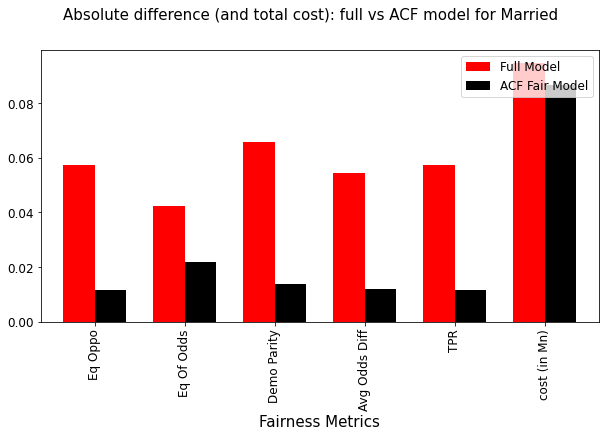

In [52]:
txt='Married'

ax = ACF_table.iloc[[0,1,3,4,7,8],:].plot.bar(x='Metrics', rot=90, width = 0.7, color=['red', 'black'], figsize=(10,5), fontsize=12)
plt.suptitle('Absolute difference (and total cost): full vs ACF model for {}'.format(txt),  
             fontsize=15, y=1)  
            


patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Fairness Metrics', fontsize=15)
plt.show()

<div class="alert alert-block alert-success">
<b>Inference:</b>
    All fairness metrics shows improvement and thus proving that the model is much bias-free in case of ACF fair model. The cost seems to have gone down in ACF fair model compared to full model. However, metrics like precision and predictive parity is showing some trade-off.
</div>

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="8b"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:1.25em;">Regression (multiple protected features)</span>
</div>

<div class="alert alert-block alert-info">
<b>Remember:</b>

- Here the target variable:
 - ProbabilityOfDefault
- The independent variables are:
 - Age
 - AppliedAmount
 - ExpectedLoss
 - LiabilitiesTotal
 - IncomeTotal
 - Interest
 - LoanDuration
 - MonthlyPayment
- The sensitive variables are:
 - NrOfDependantslessthan3
 - MaritalStatus_1.0
 - MaritalStatus_3.0
 - MaritalStatus_4.0
 </div>

In [53]:
choice ='NrOfDependantslessthan3' #'MaritalStatus_1.0' #Single MaritalStatus_3.0' 'NrOfDependantslessthan3'
txt='No of Dep Less 3'

# "NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0'

In [54]:
dataacf_Lin = datatest[['ProbabilityOfDefault','Age', 'AppliedAmount', 'ExpectedLoss', 
                        'LiabilitiesTotal', 'IncomeTotal', 'Interest', 'LoanDuration', 'MonthlyPayment',
"NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

## Full model : Linear Regression
Here we are slecting probablity of default as the target feature and would predict this value using linear regression algorithm

In [55]:
y=dataacf_Lin['ProbabilityOfDefault']*1000
x=dataacf_Lin.drop(columns=['ProbabilityOfDefault'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=696969) #6699

In [56]:
max(y)

814.587576

In [57]:
clf_full_Lin = LinearRegression().fit(X_train, y_train)
y_pred=clf_full_Lin.predict(X_test)
print("For full model:")
print("Mean Squared Error:",mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", RMSE(y_pred, y_test))
print("Mean Absolute Percentage Error:", mape(y_pred, y_test))


For full model:
Mean Squared Error: 1991.352863094925
Root Mean Squared Error: 44.62457689541633
Mean Absolute Percentage Error: 22.862083236715172


In [58]:
print("For full model:")
print(choice)
A_full=mean_squared_error(y_test[X_test[choice]==0], y_pred[X_test[choice]==0]) #pval = 0 is Privileged
B_full=mean_squared_error(y_test[X_test[choice]==1], y_pred[X_test[choice]==1]) #pval = 1 is Unprivileged
print("Mean Squared Error difference:", abs(B_full-A_full))

A_full=RMSE(y_test[X_test[choice]==0], y_pred[X_test[choice]==0]) #pval = 0 is Privileged
B_full=RMSE(y_test[X_test[choice]==1], y_pred[X_test[choice]==1]) #pval = 1 is Unprivileged
print("Root Mean Squared Error: difference", abs(B_full-A_full))


A_full=mape(y_test[X_test[choice]==0], y_pred[X_test[choice]==0]) #pval = 0 is Privileged
B_full=mape(y_test[X_test[choice]==1], y_pred[X_test[choice]==1]) #pval = 1 is Unprivileged
print("Mean Absolute Percentage Error: difference", abs(B_full-A_full))

For full model:
NrOfDependantslessthan3
Mean Squared Error difference: 296.32936663704436
Root Mean Squared Error: difference 3.452098435064137
Mean Absolute Percentage Error: difference 4.377897991079163


In [59]:
choice

'NrOfDependantslessthan3'

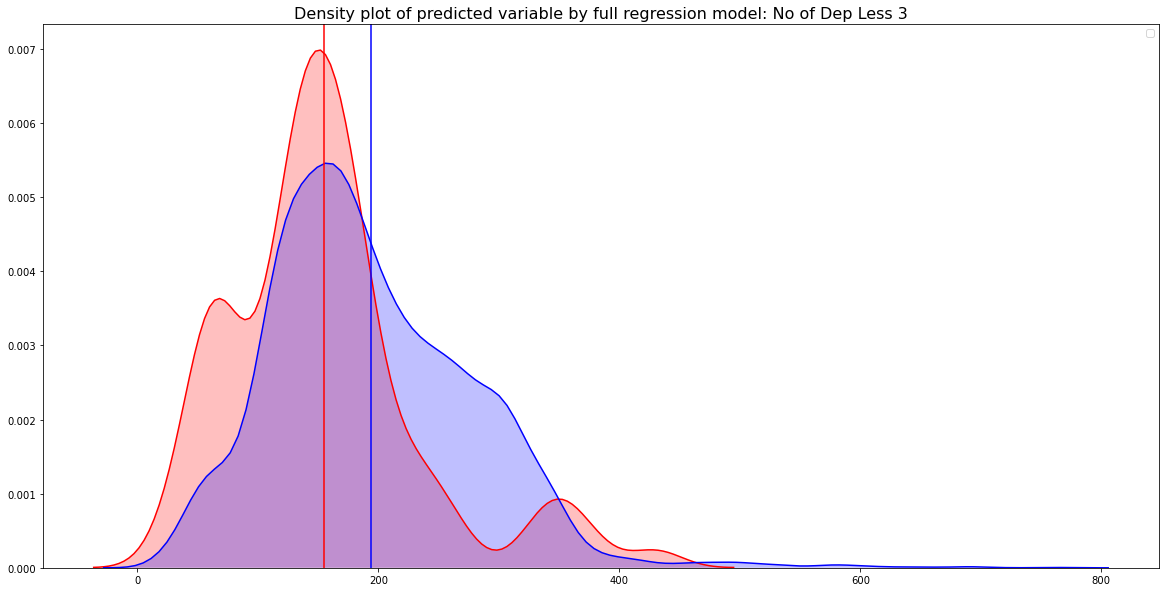

Mean difference of predicted target value (Full Model) between two groups: -39.11813397376926
Skewness difference of predicted target value (Full Model) between two groups: 0.2712255153244709
Kurtosis difference of predicted target value (Full Model) between two groups: -0.41737081397393094


In [60]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(y_pred[X_test[choice]==0], shade=True, color="r")
p1=sns.kdeplot(y_pred[X_test[choice]==1], shade=True, color="b")
#print(np.mean(y_pred[X_test[choice]==0]) - np.mean(y_pred[X_test[choice]==1]))

plt.title('Density plot of predicted variable by full regression model: {}'. format(txt), fontsize=16)
plt.axvline(np.mean(y_pred[X_test[choice]==0]), color="r")
plt.axvline(np.mean(y_pred[X_test[choice]==1]), color="b")

plt.legend('a', 'b')
plt.show()

print("Mean difference of predicted target value (Full Model) between two groups:", np.mean(y_pred[X_test[choice]==0]) - 
      np.mean(y_pred[X_test[choice]==1]))
print("Skewness difference of predicted target value (Full Model) between two groups:", skew(y_pred[X_test[choice]==0]) - 
      skew(y_pred[X_test[choice]==1]))
print("Kurtosis difference of predicted target value (Full Model) between two groups:", kurtosis(y_pred[X_test[choice]==0]) - 
      kurtosis(y_pred[X_test[choice]==1]))

In [61]:
print("Mean ratio of predicted target value (Full Model) between two groups:", np.mean(y_pred[X_test[choice]==0]) / 
      np.mean(y_pred[X_test[choice]==1]))
print("Skewness ratio of predicted target value (Full Model) between two groups:", skew(y_pred[X_test[choice]==0]) / 
      skew(y_pred[X_test[choice]==1]))
print("Kurtosis ratio of predicted target value (Full Model) between two groups:", kurtosis(y_pred[X_test[choice]==0]) / 
      kurtosis(y_pred[X_test[choice]==1]))

Mean ratio of predicted target value (Full Model) between two groups: 0.7984501297868509
Skewness ratio of predicted target value (Full Model) between two groups: 1.3014354322934767
Kurtosis ratio of predicted target value (Full Model) between two groups: 0.8074559507855933


## Additive counterfactual fair model

In [62]:
y=dataacf_Lin['ProbabilityOfDefault']*1000
x=dataacf_Lin.drop(columns=['ProbabilityOfDefault'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=696969)

**Selecting few protected / sensitive features**

In [63]:
sens=X_train[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

**Regressing each independent variable with all sensitive variables**

In [64]:
clf_age = LinearRegression().fit(sens, X_train['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_train['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_train['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_train['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_train['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_train['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_train['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_train['MonthlyPayment'])

**Residual of each models**

In [65]:
ageR = X_train['Age'] - clf_age.predict(sens)
AppliedAmountR = X_train['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_train['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_train['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_train['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_train['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_train['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_train['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)

In [66]:
df_R=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                   'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Fitting residuals to the dependent (target) variable**

In [67]:
fair = LinearRegression().fit(df_R, y_train)

**Regressing each independent variable with sensitive variables on test data**

In [68]:
sens=X_test[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]
#countersens = sens.replace({0:1, 1:0})

In [69]:
clf_age = LinearRegression().fit(sens, X_test['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_test['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_test['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_test['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_test['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_test['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_test['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_test['MonthlyPayment'])

**Residual of each model on test data**

In [70]:
ageR = X_test['Age'] - clf_age.predict(sens)
AppliedAmountR = X_test['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_test['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_test['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_test['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_test['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_test['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_test['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)

In [71]:
df_R_test=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                        'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Predicting the target variable on fair model developed above**

In [72]:
pred_fair_te = fair.predict(df_R_test)

In [73]:
print("For ACF model:")
print("Mean Squared Error:",mean_squared_error(y_test, pred_fair_te))
print("Root Mean Squared Error:", RMSE(pred_fair_te, y_test))
print("Mean Absolute Percentage Error:", mape(pred_fair_te, y_test))

For ACF model:
Mean Squared Error: 2442.6078661946876
Root Mean Squared Error: 49.422746445282534
Mean Absolute Percentage Error: 28.251163055694818


In [74]:
print(choice)
print("For ACF model:")
A_fair=mean_squared_error(y_test[sens[choice]==0], pred_fair_te[sens[choice]==0]) #pval = 0 is Privileged
B_fair=mean_squared_error(y_test[sens[choice]==1], pred_fair_te[sens[choice]==1]) #pval = 1 is Unprivileged
print("Mean Squared Error difference:", abs(B_fair-A_fair))


A_fair=RMSE(y_test[sens[choice]==0], pred_fair_te[sens[choice]==0]) #pval = 0 is Privileged
B_fair=RMSE(y_test[sens[choice]==1], pred_fair_te[sens[choice]==1]) #pval = 1 is Unprivileged
print("Root Mean Squared Error difference:", abs(B_fair-A_fair))


A_fair=mape(y_test[sens[choice]==0], pred_fair_te[sens[choice]==0]) #pval = 0 is Privileged
B_fair=mape(y_test[sens[choice]==1], pred_fair_te[sens[choice]==1]) #pval = 1 is Unprivileged
print("Mean Absolute Percentage Error difference:", abs(B_fair-A_fair))

NrOfDependantslessthan3
For ACF model:
Mean Squared Error difference: 773.6410428846839
Root Mean Squared Error difference: 7.2958061808365
Mean Absolute Percentage Error difference: 7.7870383019436


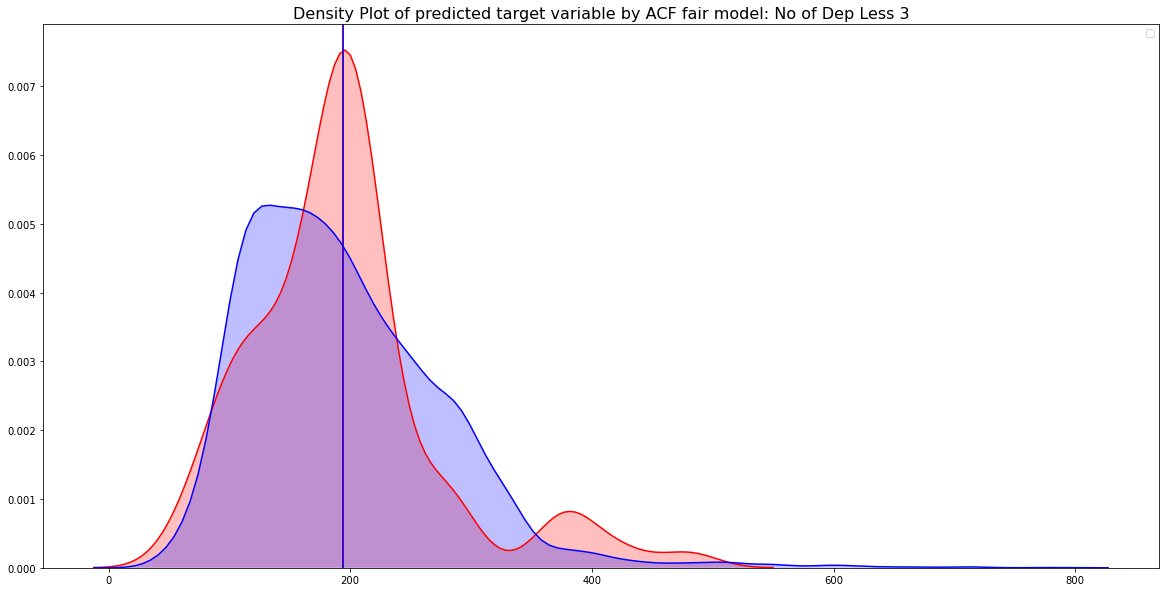

Mean difference of predicted target value (ACF Model) between two groups: 1.7053025658242404e-13
Skewness difference of predicted target value (ACF Model) between two groups: -0.013306478418257273
Kurtosis difference of predicted target value (ACF Model) between two groups: -1.270391352089538


In [75]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(pred_fair_te[sens[choice]==0], shade=True, color="r")
p1=sns.kdeplot(pred_fair_te[sens[choice]==1], shade=True, color="b")
plt.title('Density Plot of predicted target variable by ACF fair model: {}' . format(txt), fontsize=16)
plt.axvline(np.mean(pred_fair_te[sens[choice]==0]), color="r" )
plt.axvline(np.mean(pred_fair_te[sens[choice]==1]), color="b")


plt.legend('a','b')
plt.show()

print("Mean difference of predicted target value (ACF Model) between two groups:", np.mean(pred_fair_te[sens[choice]==0]) - 
      np.mean(pred_fair_te[sens[choice]==1]))
print("Skewness difference of predicted target value (ACF Model) between two groups:", skew(pred_fair_te[sens[choice]==0]) - 
      skew(pred_fair_te[sens[choice]==1]))
print("Kurtosis difference of predicted target value (ACF Model) between two groups:", kurtosis(pred_fair_te[sens[choice]==0]) - 
      kurtosis(pred_fair_te[sens[choice]==1]))

In [76]:
print("Mean ratio of predicted target value (ACF Model) between two groups:", np.mean(pred_fair_te[sens[choice]==0]) / 
      np.mean(pred_fair_te[sens[choice]==1]))
print("Skewness ratio of predicted target value (ACF Model) between two groups:", skew(pred_fair_te[sens[choice]==0]) / 
      skew(pred_fair_te[sens[choice]==1]))
print("Kurtosis ratio of predicted target value (ACF Model) between two groups:", kurtosis(pred_fair_te[sens[choice]==0]) / 
      kurtosis(pred_fair_te[sens[choice]==1]))

Mean ratio of predicted target value (ACF Model) between two groups: 1.0000000000000009
Skewness ratio of predicted target value (ACF Model) between two groups: 0.9895839027358303
Kurtosis ratio of predicted target value (ACF Model) between two groups: 0.6473668509590043


**Summary of Model performace**

Metrics  | Data | Full Model | ACF |
------------- | ------------- | ------------ | ------------ |
Mean  | 14.3 |13.5| 2.8e-14
Skewness  | -0.72|-0.90|-0.49
Kurtosis  | -0.99|-1.92|-0.44

<div class="alert alert-block alert-success">
<b>Inference:</b>
    The distribution of target value (probability of default) between two groups is quite varied in the original data (evident from the large difference in mean, skewness and kurtosis) and has worsed when a full model was developed using linear regression algorithm. However, the ACF model show that the distribution of target value among the two groups is very similar and the difference in mean, skewness and kurtosis has reduced dramatically.
</div>

<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="8c"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:1.25em;">Regression on counterfactual sensitive data (multiple protected features)</span>
</div>

<div class="alert alert-block alert-info">
<b>Remember:</b>
The theme of CF is <b>"What would have been my prediction if - all else held causally equal - I was member of another protected group?"</b>
    
Theoretically to check the need of ACF model for some predictor ${Y}$ with data ${D}$={${x_i}$, ${s_i}$}, first develop a full model ${M}$ with all features and fit the test data with as is sensitive features ${S}$ and note the predictions $\hat{Y}$ and error $\epsilon$. In next steps fit the model again with the inverse of ${S}$ i.e., ${S'}$ and find the predictions $\hat{Y'}$ and $\epsilon'$. In third step find ${E}$ as $\hat{Y} - \hat{Y'}$ and  $\epsilon$-$\epsilon'$ to satisfy:

$$
\begin{array}
{P}(\hat{Y}_{{s}={s'}}={Y} \mid {X}={x}, {S}={s'}) = {P}(\hat{Y}_{{s}={s}}={Y} \mid {X}={x}, {S}={s})
\end{array}
$$
    
In next set of steps, for ${M}_{ACF}$ model, fit the test data with as is sensitive features ${S}$ and note the predictions $\hat{Y}_{ACF}$ and error $\epsilon_{ACF}$. In next steps fit the model again with inverse of ${S}$ i.e., ${S'}$ and find the predictions $\hat{Y'}_{ACF}$. In third step find ${E'}$ as $\epsilon'_{ACF}$ as $\hat{Y}_{ACF}- \hat{Y'}_{ACF}$ and  $\epsilon_{ACF}-\epsilon'_{ACF}$ to satisfy:
$$
\begin{array}
{P}(\hat{Y}_{{s}={s'}}={Y} \mid {X}={x}, {S}={s'}) = {P}(\hat{Y}_{{s}={s}}={Y} \mid {X}={x}, {S}={s})
\end{array}
$$

The <b>[Counterfactual unfairness](https://arxiv.org/pdf/1907.01040.pdf) (CFU)</b> score would be  $\frac{1}{n}\sum(\epsilon - \epsilon_{ACF})^{2}$ or minimize $\frac{1}{n}\sum({E}$ - ${E'})^{2}$ . The aim should to minimize the CFU.
In an ideal case, the model ${M}$ should have zero $\epsilon$ given ${S'}$

Thus, ACF can be described as:

$$
\begin{array}
{}
\theta = \arg_{\theta}min \sum {l}({f_{\theta}(\hat \epsilon_{i}),{y_{i}})}
\\
where, \hat \epsilon_{i} \in {\hat \epsilon_{x_{1i}}\cdots\hat \epsilon_{x_{ni}}}
\end{array}
$$

</div>

In [77]:
dataacf_Lin = datatest[['ProbabilityOfDefault','Age', 'AppliedAmount', 'ExpectedLoss', 
                        'LiabilitiesTotal', 'IncomeTotal', 'Interest', 'LoanDuration', 'MonthlyPayment']]
sens = datatest[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

## Full model : Linear Regression
Here we are slecting probablity of default as the target feature and would predict this value using linear regression algorithm

In [78]:
fulldata = pd.concat([dataacf_Lin, sens], axis=1)

In [79]:
y=fulldata['ProbabilityOfDefault']*1000
x=fulldata.drop(columns=['ProbabilityOfDefault'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=696969) #6699

In [80]:
clf_full_Lin = LinearRegression().fit(X_train, y_train)
y_pred_F = clf_full_Lin.predict(X_test)
print("For full model:")
print("Mean Squared Error:",mean_squared_error(y_test, y_pred_F))
print("Root Mean Squared Error:", RMSE(y_pred_F, y_test))

For full model:
Mean Squared Error: 1991.352863094925
Root Mean Squared Error: 44.62457689541633


**Error for the full model with sensitive features included**

In [81]:
error = y_test - y_pred_F

### Testing the full model on counterfactual sensitive data

In [82]:
senstest=X_test[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]
test=X_test[['Age', 'AppliedAmount', 'ExpectedLoss', 
                        'LiabilitiesTotal', 'IncomeTotal', 'Interest', 'LoanDuration', 'MonthlyPayment']]

counter_senstest = senstest.replace({0:1, 1:0})
countertest = pd.concat([test, counter_senstest], axis=1)

In [83]:
y_pred_CF=clf_full_Lin.predict(countertest)
print("For full model:")
print("Mean Squared Error:",mean_squared_error(y_test, y_pred_CF))
print("Root Mean Squared Error:", RMSE(y_pred_CF, y_test))

For full model:
Mean Squared Error: 7947.534320774168
Root Mean Squared Error: 89.14894458586802


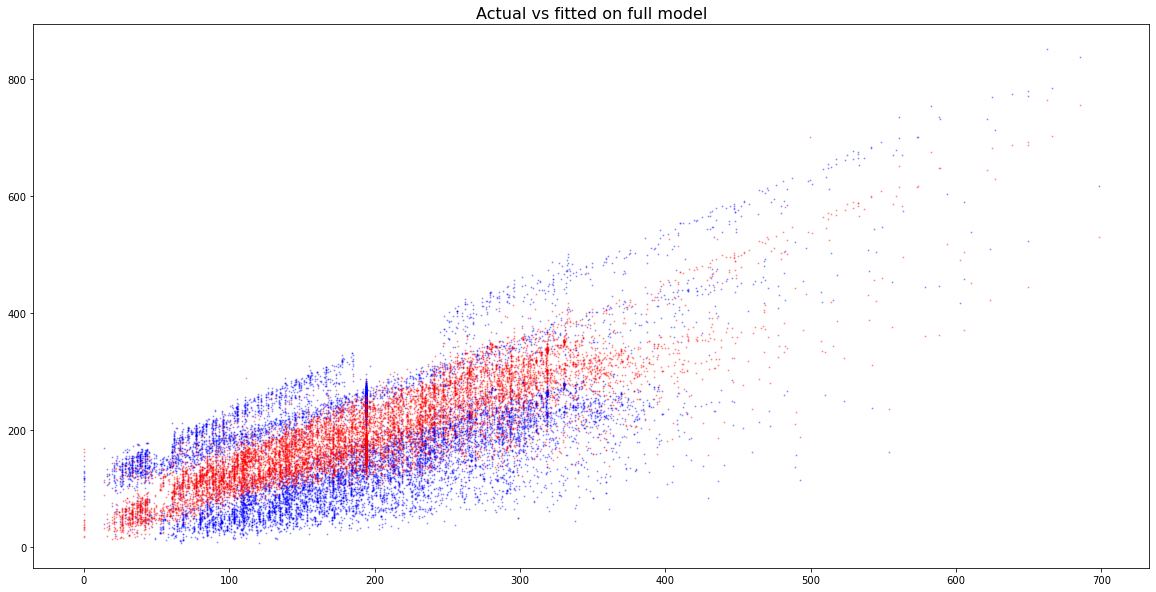

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.scatter(y_test, y_pred_CF, s=1, alpha=0.3, color='b')
plt.scatter(y_test, y_pred_F, s=1, alpha = 0.3, color='r')

plt.title('Actual vs fitted on full model', fontsize=16)


plt.show()

**Error for the full model with counter sensitive features included**

In [85]:
errorcounter = y_test - y_pred_CF

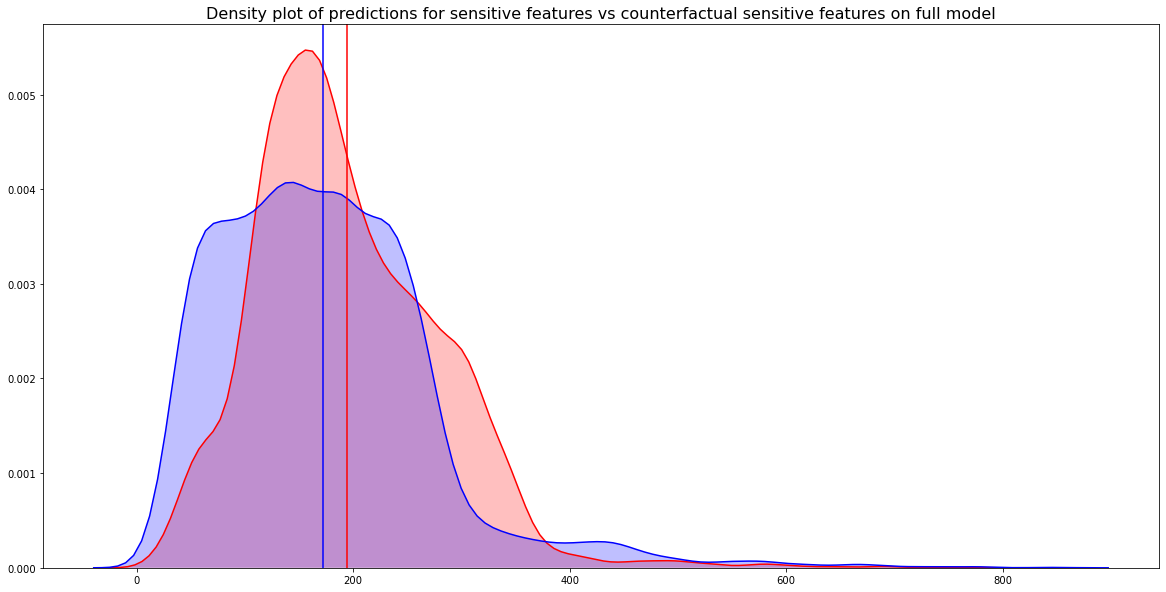

In [86]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(y_pred_F, shade=True, color="r")
p1=sns.kdeplot(y_pred_CF, shade=True, color="b")
plt.title('Density plot of predictions for sensitive features vs counterfactual sensitive features on full model', fontsize=16)
plt.axvline(np.mean(y_pred_F), color="r")
plt.axvline(np.mean(y_pred_CF), color="b")

plt.show()

**Counterfactual unfairness (CFU) score for full model**

In [87]:
CUF1 = (np.sum(np.square(errorcounter - error))/len(error))
CUF1

5949.808667508947

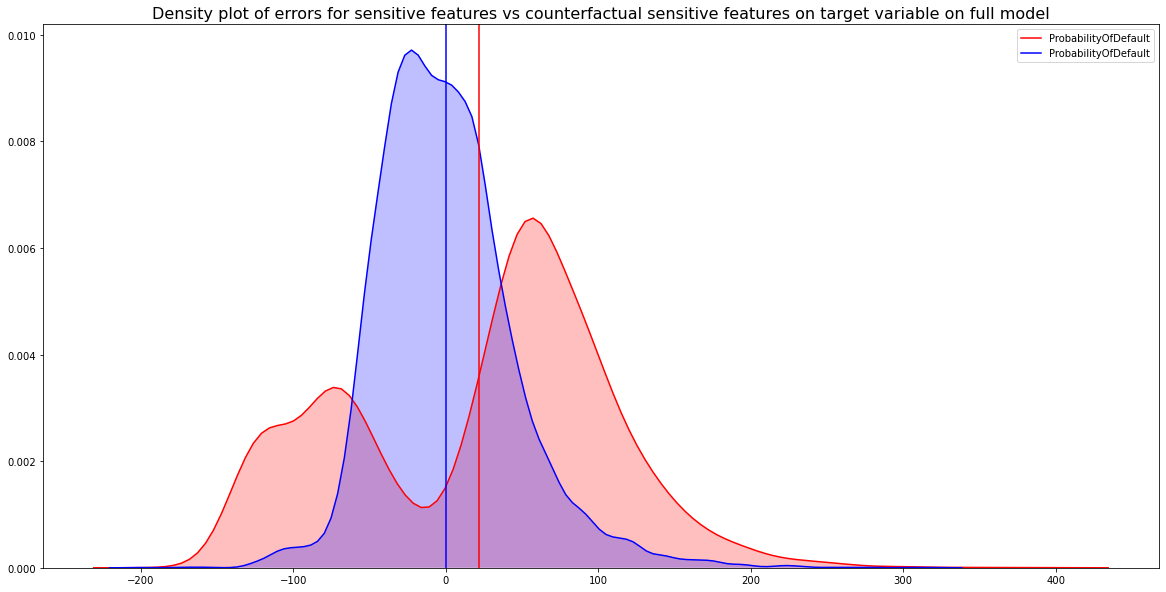

In [88]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(errorcounter, shade=True, color="r")
p1=sns.kdeplot(error, shade=True, color="b")
plt.title('Density plot of errors for sensitive features vs counterfactual sensitive features on target variable on full model', fontsize=16)
plt.axvline(np.mean(errorcounter), color="r")
plt.axvline(np.mean(error), color="b")

plt.show()

## Additive counterfactual fair model

In [89]:
dataacf_Lin = datatest[['ProbabilityOfDefault','Age', 'AppliedAmount', 'ExpectedLoss', 
                        'LiabilitiesTotal', 'IncomeTotal', 'Interest', 'LoanDuration', 'MonthlyPayment', 
                        "NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

In [90]:
y=dataacf_Lin['ProbabilityOfDefault']*1000
x=dataacf_Lin.drop(columns=['ProbabilityOfDefault'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=696969)

**Selecting few protected / sensitive features**

In [91]:
sens=X_train[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

**Regressing each independent variable with all sensitive variables**

In [92]:
clf_age = LinearRegression().fit(sens, X_train['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_train['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_train['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_train['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_train['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_train['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_train['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_train['MonthlyPayment'])

**Residual of each models**

In [93]:
ageR = X_train['Age'] - clf_age.predict(sens)
AppliedAmountR = X_train['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_train['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_train['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_train['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_train['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_train['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_train['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)


In [94]:
df_R=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                   'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Fitting residuals to the dependent (target) variable**

In [95]:
fair = LinearRegression().fit(df_R, y_train)

**Regressing each independent variable with sensitive variables on test data**

In [96]:
sens=X_test[["NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0']]

In [97]:
clf_age = LinearRegression().fit(sens, X_test['Age'])
clf_AppliedAmount = LinearRegression().fit(sens, X_test['AppliedAmount'])
clf_ExpectedLoss = LinearRegression().fit(sens, X_test['ExpectedLoss'])
clf_LiabilitiesTotal = LinearRegression().fit(sens, X_test['LiabilitiesTotal'])
clf_IncomeTotal = LinearRegression().fit(sens, X_test['IncomeTotal'])
clf_Interest = LinearRegression().fit(sens, X_test['Interest'])
clf_LoanDuration = LinearRegression().fit(sens, X_test['LoanDuration'])
clf_MonthlyPayment = LinearRegression().fit(sens, X_test['MonthlyPayment'])

**Residual of each model on test data**

In [98]:
ageR = X_test['Age'] - clf_age.predict(sens)
AppliedAmountR = X_test['AppliedAmount'] - clf_AppliedAmount.predict(sens)
ExpectedLossR = X_test['ExpectedLoss'] - clf_ExpectedLoss.predict(sens)
LiabilitiesTotalR = X_test['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(sens)
IncomeTotalR = X_test['IncomeTotal'] - clf_IncomeTotal.predict(sens)
InterestR = X_test['Interest'] - clf_Interest.predict(sens)
LoanDurationR = X_test['LoanDuration'] - clf_LoanDuration.predict(sens)
MonthlyPaymentR = X_test['MonthlyPayment'] - clf_MonthlyPayment.predict(sens)


In [99]:
df_R_test=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                        'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

**Predicting the target variable on fair model developed above**

In [100]:
pred_fair_te = fair.predict(df_R_test)

In [101]:
print("For ACF model:")
print("Mean Squared Error:",mean_squared_error(y_test, pred_fair_te))
print("Root Mean Squared Error:", RMSE(pred_fair_te, y_test))
print("Mean Absolute Percentage Error:", mape(pred_fair_te, y_test))

For ACF model:
Mean Squared Error: 2442.6078661946876
Root Mean Squared Error: 49.422746445282534
Mean Absolute Percentage Error: 28.251163055694818


**Error for the ACF model with residuals of sensitive features**

In [102]:
acferror = pd.Series(y_test - pred_fair_te, name="Sensitive data")

### Testing the ACF model on counterfactual sensitive data

In [103]:
countersens = sens.replace({0:1, 1:0})

In [104]:
#clf_age = LinearRegression().fit(countersens, X_test['Age'])
#clf_AppliedAmount = LinearRegression().fit(countersens, X_test['AppliedAmount'])
#clf_ExpectedLoss = LinearRegression().fit(countersens, X_test['ExpectedLoss'])
#clf_LiabilitiesTotal = LinearRegression().fit(countersens, X_test['LiabilitiesTotal'])
#clf_IncomeTotal = LinearRegression().fit(countersens, X_test['IncomeTotal'])
#clf_Interest = LinearRegression().fit(countersens, X_test['Interest'])
#clf_LoanDuration = LinearRegression().fit(countersens, X_test['LoanDuration'])
#clf_MonthlyPayment = LinearRegression().fit(countersens, X_test['MonthlyPayment'])

In [105]:
ageR = X_test['Age'] - clf_age.predict(countersens)
AppliedAmountR = X_test['AppliedAmount'] - clf_AppliedAmount.predict(countersens)
ExpectedLossR = X_test['ExpectedLoss'] - clf_ExpectedLoss.predict(countersens)
LiabilitiesTotalR = X_test['LiabilitiesTotal'] - clf_LiabilitiesTotal.predict(countersens)
IncomeTotalR = X_test['IncomeTotal'] - clf_IncomeTotal.predict(countersens)
InterestR = X_test['Interest'] - clf_Interest.predict(countersens)
LoanDurationR = X_test['LoanDuration'] - clf_LoanDuration.predict(countersens)
MonthlyPaymentR = X_test['MonthlyPayment'] - clf_MonthlyPayment.predict(countersens)


In [106]:
df_R_test=pd.DataFrame({'ageR':ageR, 'AppliedAmountR':AppliedAmountR, 'ExpectedLossR':ExpectedLossR, 
                        'LiabilitiesTotalR':LiabilitiesTotalR,
                'IncomeTotalR':IncomeTotalR, 'InterestR':InterestR, 'LoanDurationR':LoanDurationR,
                   'MonthlyPaymentR':MonthlyPaymentR})

In [107]:
pred_fair_te_acf = fair.predict(df_R_test)

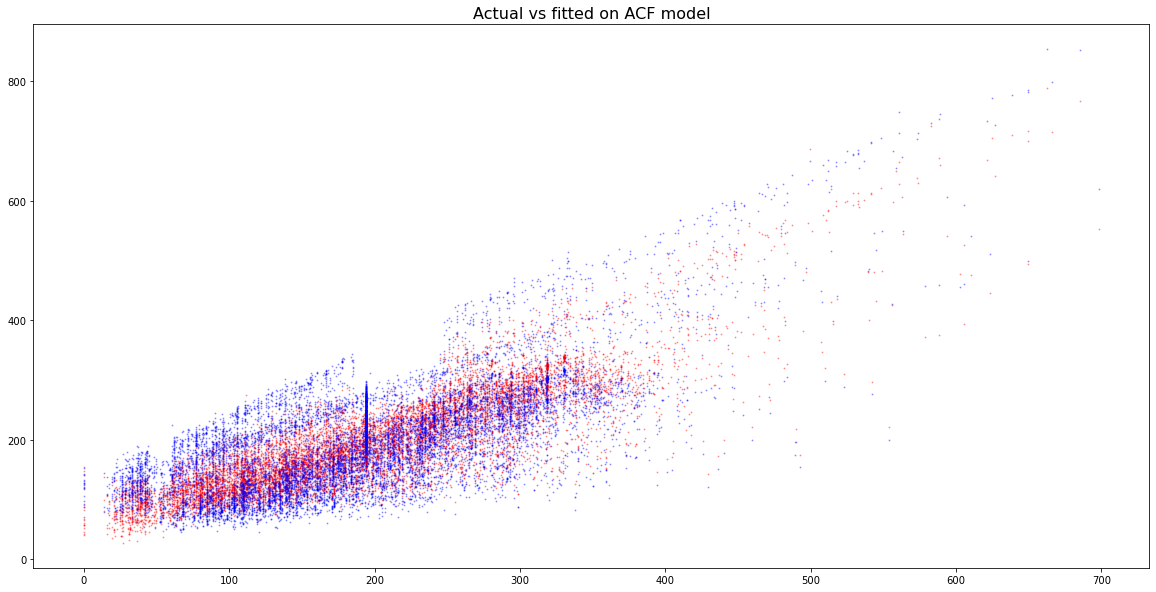

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(y_test, pred_fair_te, s=1, alpha=0.3, color='r')
plt.scatter(y_test, pred_fair_te_acf, s=1, alpha=0.3, color='b')


plt.title('Actual vs fitted on ACF model', fontsize=16)

plt.show()


**Error for the ACF model with residuals of sensitive features**

In [109]:
counter_acferror = pd.Series(y_test - pred_fair_te_acf, name="Counterfactual sensitive data")

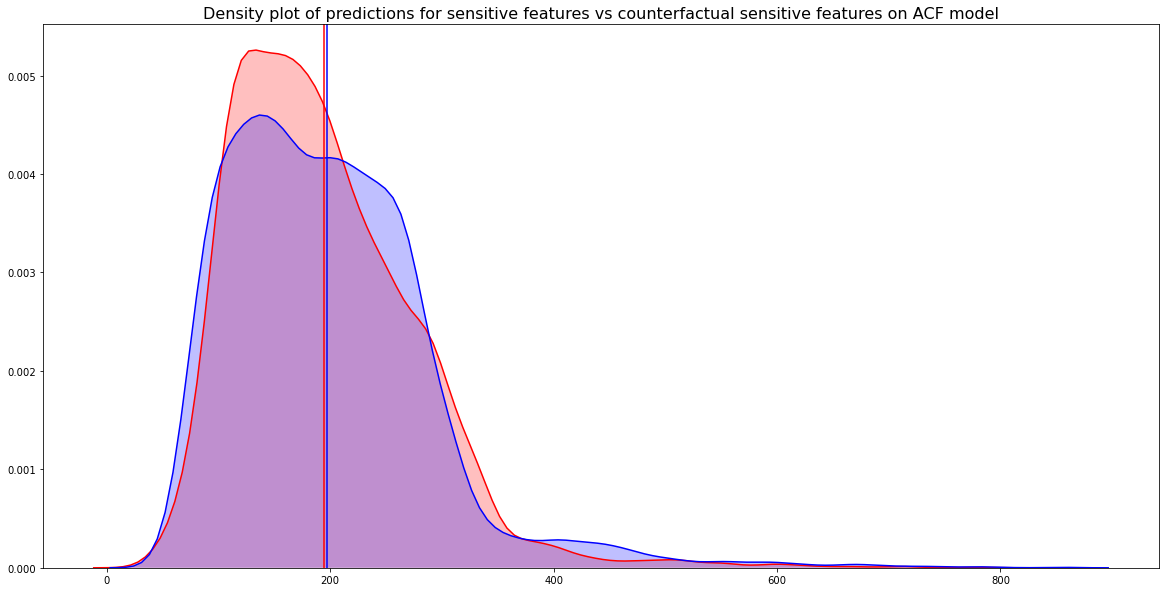

In [110]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(pred_fair_te, shade=True, color="r")
p1=sns.kdeplot(pred_fair_te_acf, shade=True, color="b")
plt.title('Density plot of predictions for sensitive features vs counterfactual sensitive features on ACF model', fontsize=16)
plt.axvline(np.mean(pred_fair_te), color="r")
plt.axvline(np.mean(pred_fair_te_acf), color="b")

plt.show()

**Counterfactual unfairness (CFU) score for ACF model**

In [111]:
CUF2 = (np.sum(np.square(counter_acferror - acferror))/len(acferror))
CUF2

1590.2688192490746

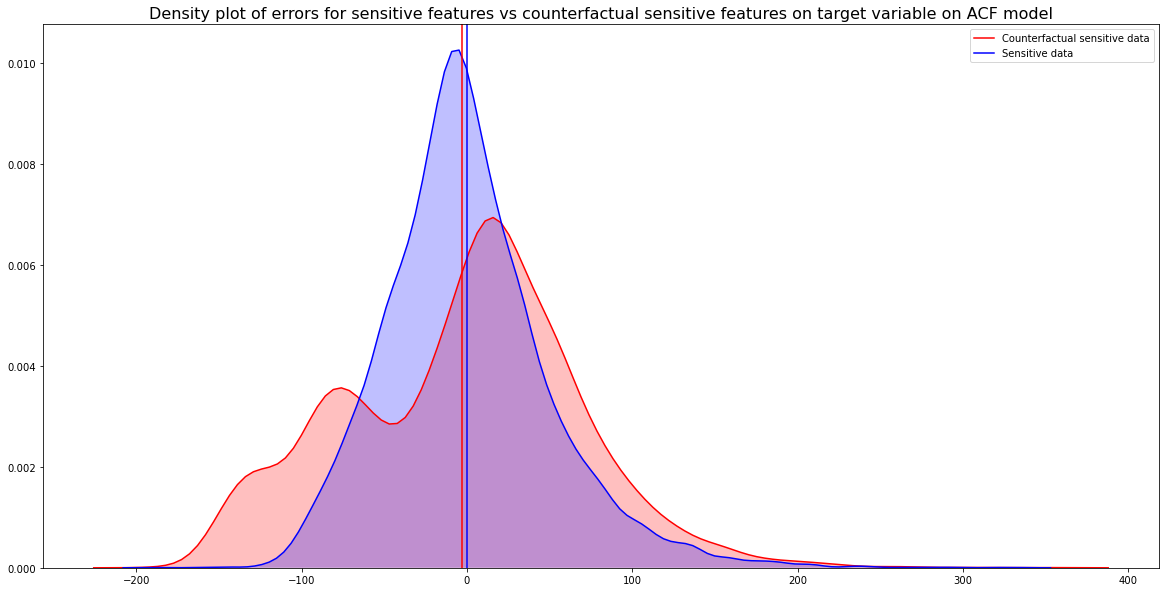

In [112]:
plt.figure(figsize=(20,10))
p1=sns.kdeplot(counter_acferror, shade=True, color="r")
p1=sns.kdeplot(acferror, shade=True, color="b")
plt.title('Density plot of errors for sensitive features vs counterfactual sensitive features on target variable on ACF model', fontsize=16)
plt.axvline(np.mean(counter_acferror), color="r")
plt.axvline(np.mean(acferror), color="b")

plt.show()

<div class="alert alert-block alert-success">
<b>Inference:</b> 
    The result from the CFU technique showed that CFUfull was 5949.80 and CFUacf was 1590.26. The CFU score for full model is much higher than CFU score of the ACF model and the distribution of predictions for factual and counterfactual in case of ACF is quite similar. This illustrates that the ACF model prediction has very less (compared to vanilla model) impact of sensitive data. In other words, the prediction wont change drastically if the fact of sensitive / protected feature is reverses or is made counterfactual.
</div>